In [3]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=f5a726790a241cc797ef7460e5e151a4a8e90ffe5affc729108e15e5ff3091ea
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


**IMPORTING THE COAUTHOR DATSET FROM PYTORCH GEOMETRIC AND DISPLAYING METADATA ABOUT THE DATASET**

In [4]:
from torch_geometric.datasets import Coauthor
from torch_geometric.transforms import NormalizeFeatures

dataset = Coauthor(root='.', name='CS', transform=NormalizeFeatures())

print()

data=dataset[0]
dataset_name = 'cs'
x = data.x
y = data.y
edge_index = data.edge_index

print('Coauthor dataset:', dataset_name)
print('Number of graphs:', len(dataset))
print('Number of nodes (first graph):', data.num_nodes)
print('Number of edges (first graph):', data.num_edges)
print('Number of classes:', dataset.num_classes)

Processing...
Done!



Coauthor dataset: cs
Number of graphs: 1
Number of nodes (first graph): 18333
Number of edges (first graph): 163788
Number of classes: 15


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

**SPLIT DATA INTO TRAIN AND TEST-HERE 80-20 SPLIT**

In [6]:

train_ratio = 0.80
num_samples = data.x.shape[0]
num_train = int(train_ratio * num_samples)

torch.manual_seed(342)
indices = torch.randperm(num_samples)
train_indices = indices[:num_train]
test_indices = indices[num_train:]

train_mask = torch.zeros(num_samples, dtype=torch.bool)
train_mask[train_indices] = 1
test_mask = ~train_mask

**MODEL DEFINITION BY DEFINING GCN MODEL AND EXTRACTING NODE EMBEDDINGS**

In [7]:

import torch
import torch.nn.functional as F
import torch_geometric.nn.norm as N
from torch_geometric.nn import TransformerConv, GCNConv


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conva = N.BatchNorm(hidden_channels)
        self.conv2 = TransformerConv(hidden_channels, hidden_channels, heads=2)
        self.convb = N.BatchNorm(hidden_channels * 2)
        self.conv3 = TransformerConv(hidden_channels * 2, hidden_channels, heads=4, concat=False)
        self.output = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conva(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.convb(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.output(x)
        embeddings = x
        x = F.log_softmax(x, dim=1)
        return x, embeddings

**CREATING INSTANCE OF GCN MODEL**

In [8]:

model = GCN(in_channels=6805, hidden_channels=128, num_classes=15)

**SAVING THE STATE AS PRE-TRAINED GCN MODEL ON 100 EPOCHS**

In [9]:

model.load_state_dict(torch.load("/content/trained_model.pth"))


<All keys matched successfully>

**NODE EMBEDDINGS ARE EXTRACTED SIMULTANEOUSLY DURING PRE-TRAINING AND IS IMPORTED INTO COLAB ENVIRONMENT**

In [10]:
import torch


path_to_saved_embeddings = '/content/saved_embeddings.pt'


loaded_embeddings = torch.load(path_to_saved_embeddings)


**SPLITTING TRAINING DATA INTO SUPPORT AND QUERY SET- 5 RANDOMIZED SAMPLES ARE CHOSED FOR EVERY LABEL IN THE SUPPORT SET DURING TRAINING, AND THE REST OF THE SAMPLES ARE APPENDED TO THE QUERY SET**

In [11]:

import torch

class_labels = data.y.tolist()

support_set_train = {label: [] for label in range(15)}
query_set_train = {label: [] for label in range(15)}

shuffled_train_indices = torch.randperm(len(train_indices))

for i in shuffled_train_indices:
    label = class_labels[i]
    if len(support_set_train[label]) < 5:

        support_set_train[label].append(i)
    else:

        query_set_train[label].append(i)

max_query_nodes_per_class = min(len(train_indices) - 5 * 15, len(train_indices) // 2)

for label in range(15):
    remaining_indices = [i for i in shuffled_train_indices if class_labels[i] == label and i not in support_set_train[label]]
    sampled_indices = torch.randperm(len(remaining_indices))[:max_query_nodes_per_class]
    for idx in sampled_indices:
        query_set_train[label].append(remaining_indices[idx])

support_set_train_tensors = {label: torch.tensor(indices) for label, indices in support_set_train.items()}
query_set_train_tensors = {label: torch.tensor(indices) for label, indices in query_set_train.items()}

**SPLITTING OF TESTING DATA INTO SUPPORT AND QUERY TEST TENSORS IN A SIMILAR FASHION**

In [12]:
import torch

class_labels = data.y.tolist()

support_set_test = {label: [] for label in range(15)}
query_set_test = {label: [] for label in range(15)}

class_labels_test = [class_labels[i] for i in test_indices]

for i, label in zip(test_indices, class_labels_test):
    if len(support_set_test[label]) < 5:

        support_set_test[label].append(i)
    else:

        query_set_test[label].append(i)


for label in range(15):
    remaining_indices_test = [i for i in test_indices if class_labels[i] == label and i not in support_set_test[label]]
    for idx in remaining_indices_test:
        query_set_test[label].append(idx)

support_set_test_tensors = {label: torch.tensor(indices) for label, indices in support_set_test.items()}
query_set_test_tensors = {label: torch.tensor(indices) for label, indices in query_set_test.items()}


**CREATING SUPPORT AND QUERY MASK FOR TRAIN AND TEST DATA**

In [13]:
import torch


num_samples = data.x.shape[0]


support_mask_train = torch.zeros(num_samples, dtype=torch.bool)
query_mask_train = torch.zeros(num_samples, dtype=torch.bool)


for label, indices in support_set_train_tensors.items():
    support_mask_train[indices] = 1

for label, indices in query_set_train_tensors.items():
    query_mask_train[indices] = 1


support_mask_test = torch.zeros(num_samples, dtype=torch.bool)
query_mask_test = torch.zeros(num_samples, dtype=torch.bool)

for label, indices in support_set_test_tensors.items():
    support_mask_test[indices] = 1


for label, indices in query_set_test_tensors.items():
    query_mask_test[indices] = 1


**COMPUTING SUPPORT AND QUERY SET TRAIN EMBEDDINGS FROM LOADED NODE EMBEDDINGS AND SUPPORT AND QUERY SET TRAIN TENSORS**

In [14]:
support_set_train_embeddings = {label: loaded_embeddings[indices] for label, indices in support_set_train_tensors.items()}
query_set_train_embeddings = {label: loaded_embeddings[indices] for label, indices in query_set_train_tensors.items()}

**COMPUTING SUPPORT AND QUERY SET TEST EMBEDDINGS FROM LOADED NODE EMBEDDINGS AND SUPPORT AND QUERY SET TEST TENSORS**

In [15]:
support_set_test_embeddings = {label: loaded_embeddings[indices] for label, indices in support_set_test_tensors.items()}
query_set_test_embeddings = {label: loaded_embeddings[indices] for label, indices in query_set_test_tensors.items()}

**VISUALIZING LOADED EMBEDDINGS**

In [16]:
loaded_embeddings

tensor([[  4.2822,   3.9922,   9.3317,  ...,  -0.4739,  18.9469,   0.6294],
        [ -6.4788,  -3.5320,  15.2293,  ...,  -8.5810,  -3.6425,  -9.1166],
        [  3.2411,  -2.4157,   6.9595,  ...,  -3.3180,  21.7879,   2.1165],
        ...,
        [ 23.1275,  -3.7028,  -3.9281,  ...,   8.5188,  -2.5417,  -3.4825],
        [ -0.0391,  -1.4592,  -0.7873,  ...,  -3.8255,   3.4028,  -4.6730],
        [ -3.8752, -13.5939,  -7.3374,  ..., -12.2561,  -9.6389,  -3.5569]],
       requires_grad=True)

**FUNCTION TO COMPUTE EUCLIDEAN DISTANCE BETWEEN QUERY EMBEDDINGS AND PROTOTYPES/CENTROIDS GENERATED FROM SUPPORT EMBEDDINGS**

In [17]:

import torch
import torch.nn.functional as F

def compute_euclidean_distances(query_embeddings, centroids_tensor):
    query_embeddings_list = [embeddings for embeddings in query_embeddings.values()]
    query_embeddings_tensor = torch.cat(query_embeddings_list)

    expanded_query_embeddings = query_embeddings_tensor.unsqueeze(1)

    distances = torch.norm(expanded_query_embeddings - centroids_tensor, dim=2)

    return distances

**FUNCTION TO EXTRACT GROUND TRUTH LABELS FOR QUERY SET TRAIN TENSORS**

In [18]:
import torch

def extract_ground_truth_labels(query_set_train_tensors, class_labels, num_classes):
    query_set_train_ground_truth_labels = []
    for label in range(num_classes):
        query_indices = query_set_train_tensors[label].tolist()
        query_labels = [class_labels[i] for i in query_indices]
        query_set_train_ground_truth_labels.extend(query_labels)

    query_set_train_ground_truth_labels = torch.tensor(query_set_train_ground_truth_labels)
    return query_set_train_ground_truth_labels


**FUNCTION TO EXTRACT GROUND TRUTH LABELS FOR QUERY SET TEST TENSORS**

In [21]:
import torch

def extract_ground_truth_labels_test(query_set_test_tensors, class_labels, num_classes):
    query_set_ground_truth_labels = []
    for label in range(num_classes):
        indices = query_set_test_tensors[label].tolist()
        labels = [class_labels[i] for i in indices]
        query_set_ground_truth_labels.extend(labels)

    query_set_ground_truth_labels = torch.tensor(query_set_ground_truth_labels)
    return query_set_ground_truth_labels



#EPISODIC TRAINING LOOP:
A training loop is performed for 100 episodes-In each episode,

1)It computes the centroids/prototypes for the support set using pre-computed support set embeddings.

2)Calculates the distances between query set embeddings and the class centroids.

3)Calculates prototypical loss using negative log likelihood loss, from softmax probabilities.

4)Uses this loss for back propagation and parameter updates.

5)Episodic train accuracy is computed for the support train set, and episodic test accuracy is computed for the query train set.

4)The average episodic train accuracy is finally computed for over a 100 episodes,as the sum of train accuracies divided by the total number of episodes.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.NLLLoss()

trains = []
tests = []

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

model.train()

num_episodes = 100

num_classes = 15

for episode in range(num_episodes):


    support_set_train_embeddings = {label: loaded_embeddings[indices] for label, indices in support_set_train_tensors.items()}
    class_centroids = {label: torch.mean(embeddings, dim=0) for label, embeddings in support_set_train_embeddings.items()}


    centroids_tensor_train = torch.stack([class_centroids[label] for label in range(num_classes)], dim=0)

    distances = compute_euclidean_distances(query_set_train_embeddings, centroids_tensor_train)


    distances_with_grad = torch.tensor(distances, requires_grad=True)

    log_probs = F.log_softmax(-distances_with_grad, dim=1)


    query_labels_train = extract_ground_truth_labels(query_set_train_tensors, class_labels, num_classes)
    loss_train = F.nll_loss(log_probs, query_labels_train)


    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    scheduler.step()


    with torch.no_grad():
        out, _ = model(data.x, data.edge_index)
        pred_probs = F.softmax(out, dim=1)
        pred_labels = pred_probs.argmax(dim=1)

    support_pred_labels = pred_labels[support_mask_train]
    support_true_labels = data.y[support_mask_train]
    train_acc = (support_pred_labels == support_true_labels).sum().item() / support_mask_train.sum().item()


    query_pred_labels = pred_labels[query_mask_train]
    query_true_labels = data.y[query_mask_train]
    test_acc = (query_pred_labels == query_true_labels).sum().item() / query_mask_train.sum().item()

    trains.append(train_acc)
    tests.append(test_acc)
    print(f"Episode: {episode+1}, Loss: {loss_train.item():.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")


avg_train_accuracy = sum(trains) / num_episodes
print(f"Average Episodic Train Accuracy: {avg_train_accuracy:.4f}")


















<ipython-input-20-2f1b45ea93cc>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distances_with_grad = torch.tensor(distances, requires_grad=True)


Episode: 1, Loss: 0.6406, Train Accuracy: 0.9467, Test Accuracy: 0.9776
Episode: 2, Loss: 0.6406, Train Accuracy: 0.9867, Test Accuracy: 0.9766
Episode: 3, Loss: 0.6406, Train Accuracy: 0.9600, Test Accuracy: 0.9752
Episode: 4, Loss: 0.6406, Train Accuracy: 0.9600, Test Accuracy: 0.9768
Episode: 5, Loss: 0.6406, Train Accuracy: 0.9600, Test Accuracy: 0.9768
Episode: 6, Loss: 0.6406, Train Accuracy: 0.9467, Test Accuracy: 0.9749
Episode: 7, Loss: 0.6406, Train Accuracy: 0.9600, Test Accuracy: 0.9770
Episode: 8, Loss: 0.6406, Train Accuracy: 0.9467, Test Accuracy: 0.9772
Episode: 9, Loss: 0.6406, Train Accuracy: 0.9600, Test Accuracy: 0.9759
Episode: 10, Loss: 0.6406, Train Accuracy: 0.9600, Test Accuracy: 0.9768
Episode: 11, Loss: 0.6406, Train Accuracy: 0.9733, Test Accuracy: 0.9781
Episode: 12, Loss: 0.6406, Train Accuracy: 0.9733, Test Accuracy: 0.9769
Episode: 13, Loss: 0.6406, Train Accuracy: 0.9467, Test Accuracy: 0.9760
Episode: 14, Loss: 0.6406, Train Accuracy: 0.9867, Test Accu

**AFTER TRAINING LOOP COMPLETE, PLOTTING TRAIN AND TEST ACCURACY OVER EPISODES DURING TRAINING**

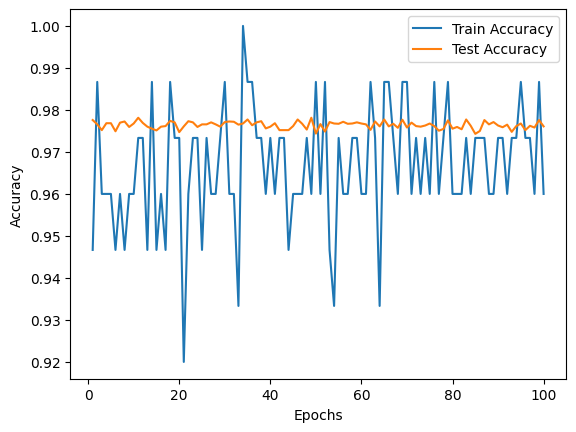

In [26]:
import matplotlib.pyplot as plt



epochs = range(1, num_episodes + 1)
plt.plot(epochs, trains, label='Train Accuracy')
plt.plot(epochs, tests, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**EVALUATION OF TRAINED MODEL DONE ON TESTING SET,CONFUSION MATRIX FOR QUERY TEST NODES-ACTUAL VS PREDICTED PLOTTED**

Average Episodic Test Accuracy: 0.8939


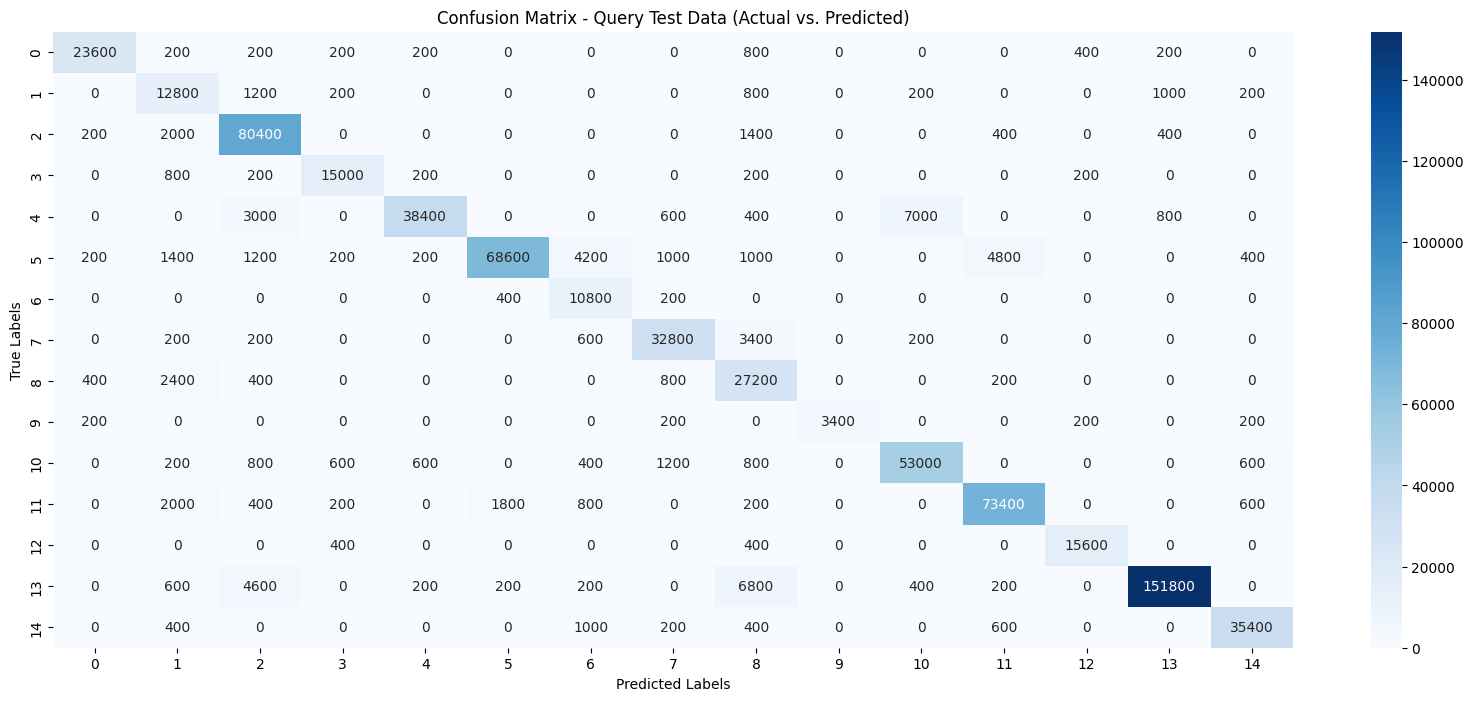

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


model.eval()


true_labels_list = []
pred_labels_list = []


num_episodes_test = 100


test_accs = []

for episode in range(num_episodes_test):


    support_set_test_embeddings = {label: loaded_embeddings[indices] for label, indices in support_set_test_tensors.items()}
    class_centroids = {label: torch.mean(embeddings, dim=0) for label, embeddings in support_set_test_embeddings.items()}


    centroids_tensor_test = torch.stack([class_centroids[label] for label in range(num_classes)], dim=0)


    query_set_test_embeddings = {label: loaded_embeddings[indices] for label, indices in query_set_test_tensors.items()}
    distances = compute_euclidean_distances(query_set_test_embeddings, centroids_tensor_test)
    log_probs = F.log_softmax(-distances, dim=1)


    query_labels_test = extract_ground_truth_labels_test(query_set_test_tensors, class_labels, num_classes)
    query_pred_labels = log_probs.argmax(dim=1)
    test_acc = (query_pred_labels == query_labels_test).sum().item() / len(query_labels_test)
    test_accs.append(test_acc)


    true_labels_list.append(query_labels_test.cpu().numpy())
    pred_labels_list.append(query_pred_labels.cpu().numpy())


avg_test_accuracy = sum(test_accs) / num_episodes_test
print(f"Average Episodic Test Accuracy: {avg_test_accuracy:.4f}")


true_labels_flat = np.concatenate(true_labels_list)
pred_labels_flat = np.concatenate(pred_labels_list)


conf_matrix_test = confusion_matrix(true_labels_flat, pred_labels_flat)


plt.figure(figsize=(20,8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Query Test Data (Actual vs. Predicted)")
plt.show()



**PLOTTING CONFUSION MATRIX FOR ACTUAL VS PREDICTED LABELS ON QUERY TRAIN DATA**

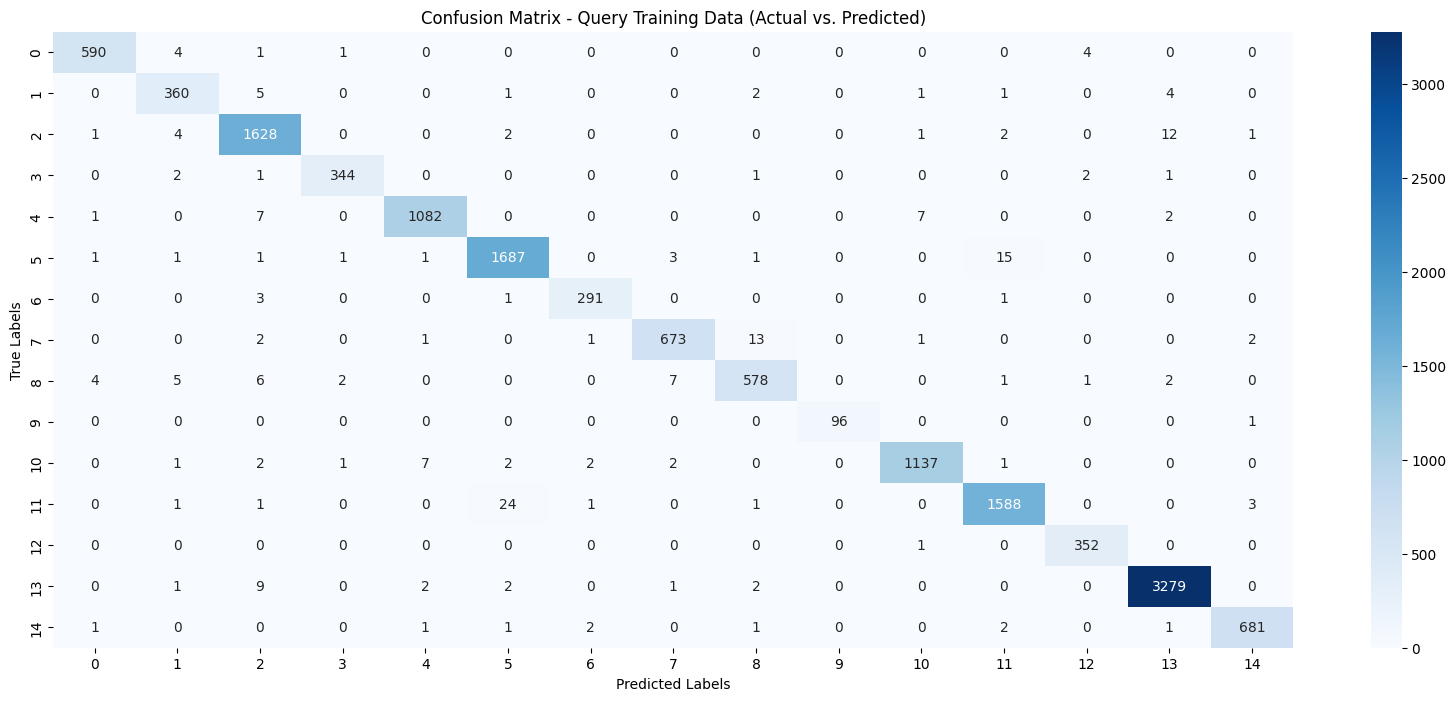

In [27]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


model.eval()
with torch.no_grad():
    out, _ = model(data.x, data.edge_index)
    pred_probs = F.softmax(out, dim=1)
    pred_labels = pred_probs.argmax(dim=1)


true_labels = data.y[query_mask_train]


conf_matrix = confusion_matrix(true_labels.cpu().numpy(), pred_labels[query_mask_train].cpu().numpy())

plt.figure(figsize=(20, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Query Training Data (Actual vs. Predicted)")
plt.show()
